# Benchmark workflow execution

This notebook checks the overhead added to the actual computations by ewoks.

In [1]:
import time
import matplotlib.pyplot as plt
from ewoksutils.import_utils import qualname
from ewoks import execute_graph
from ewokscore.tests.examples.tasks.addfunc import addfunc

Exclude importing from the benchmark

In [2]:
import ewoksppf  # noqa F401
import ewoksdask  # noqa F401

Define a workflow for benchmarking

In [3]:
def generate_graph(nbranches=1, nodes_per_branch=10):
    task_identifier = qualname(addfunc)
    nodes = []
    links = []
    for ibranch in range(nbranches):
        node_id1 = None
        for inode in range(nodes_per_branch):
            node_id2 = f"{ibranch}-{inode}"
            nodes.append(
                {
                    "id": node_id2,
                    "task_type": "method",
                    "task_identifier": task_identifier,
                    "default_inputs": [{"name": "arg", "value": 0}],
                }
            )
            if node_id1:
                links.append(
                    {
                        "source": node_id1,
                        "target": node_id2,
                        "data_mapping": [
                            {"source_output": "return_value", "target_input": "arg"}
                        ],
                    }
                )
            node_id1 = node_id2
    return {"graph": {"id": "test"}, "nodes": nodes, "links": links}

Pure python equivalent of the workflow

In [4]:
def prefunc_raw(**kw):
    return kw


def timefunc_raw(kw, **_):
    result = dict()
    for ibranch in range(kw["nbranches"]):
        arg = 0
        for inode in range(kw["nodes_per_branch"]):
            arg = addfunc(arg)
        name = f"{ibranch}-{inode}"
        result[name] = arg
    return result

Benchmark with varying number of nodes and branches

In [5]:
def bench(prefunc, timefunc, title, nrepeats=3, nnodesmax=200, **timefuncopts):
    plt.title(title)
    for i in range(0, 7, 2):
        nbranches = max(i, 1)
        x = []
        y = []
        nnodespbmax = nnodesmax // nbranches
        for j in range(0, nnodespbmax, max(nnodespbmax // 10, 1)):
            n = dt = 0
            for k in range(nrepeats):
                nodes_per_branch = max(j, 1)
                graph = prefunc(nbranches=nbranches, nodes_per_branch=nodes_per_branch)
                t0 = time.perf_counter_ns()
                timefunc(graph, **timefuncopts)
                t1 = time.perf_counter_ns()
                nk = nbranches * nodes_per_branch
                n += nk
                dt += (t1 - t0) * 1e-6 / nk
            x.append(n / nrepeats)
            y.append(dt / nrepeats)
        x, y = list(zip(*sorted(zip(x, y))))

        plt.plot(x, y, label=f"{nbranches} branches")
        plt.xlabel("# nodes")
        plt.ylabel("Time/# nodes (msec)")
        plt.legend()
    plt.gca().set_prop_cycle(None)

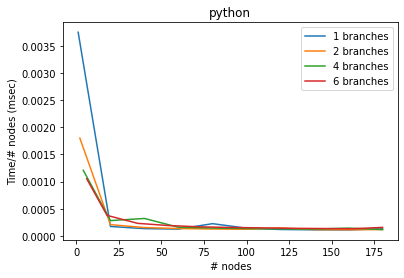

In [6]:
bench(prefunc_raw, timefunc_raw, "python")

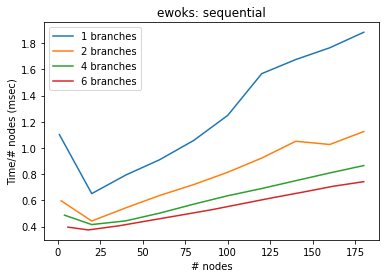

In [7]:
bench(generate_graph, execute_graph, "ewoks: sequential")

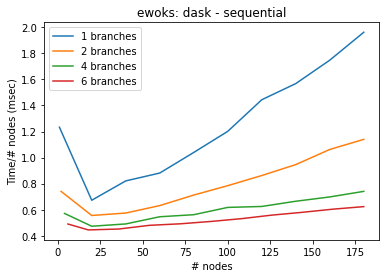

In [8]:
bench(generate_graph, execute_graph, "ewoks: dask - sequential", engine="dask")

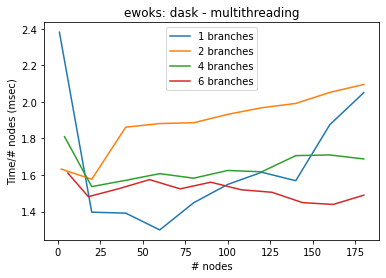

In [9]:
bench(
    generate_graph,
    execute_graph,
    "ewoks: dask - multithreading",
    engine="dask",
    scheduler="multithreading",
)

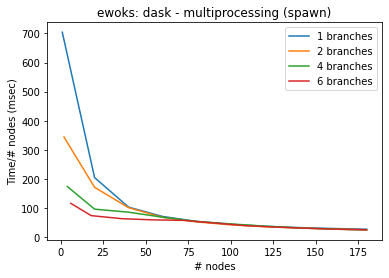

In [10]:
bench(
    generate_graph,
    execute_graph,
    "ewoks: dask - multiprocessing (spawn)",
    engine="dask",
    scheduler="multiprocessing",
    scheduler_options={"context": "spawn"},
)

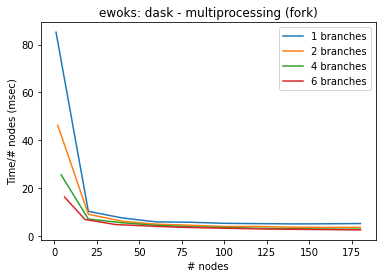

In [11]:
bench(
    generate_graph,
    execute_graph,
    "ewoks: dask - multiprocessing (fork)",
    engine="dask",
    scheduler="multiprocessing",
    scheduler_options={"context": "fork"},
)

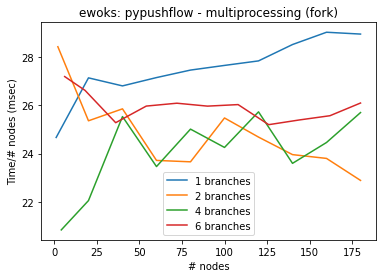

In [12]:
bench(
    generate_graph,
    execute_graph,
    "ewoks: pypushflow - multiprocessing (fork)",
    engine="ppf",
)

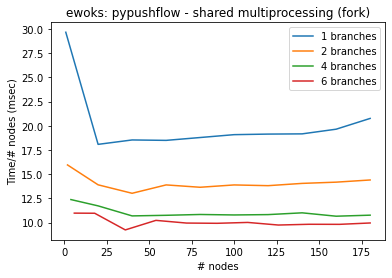

In [13]:
bench(
    generate_graph,
    execute_graph,
    "ewoks: pypushflow - scaling multiprocessing (fork)",
    engine="ppf",
    scaling_workers=False,
)